In [1]:
import torch
import torchvision
import torchvision.transforms.functional as F
from PIL import Image
import time
import os
import shutil
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
from time import gmtime, strftime

device = 'cuda:0'

ModuleNotFoundError: No module named 'torch'

In [2]:
strftime("%a, %d %b %Y %H:%M:%S +0000", gmtime())


'Sun, 05 Feb 2023 13:20:25 +0000'

# <font color= LimeGreen> Model </font>


In [3]:
chair_detection_model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5x6.pt',device=device)

Using cache found in C:\Users\s.ezati/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-1-21 Python-3.7.6 torch-1.12.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)

Fusing layers... 
YOLOv5x6 summary: 574 layers, 140730220 parameters, 0 gradients
Adding AutoShape... 


In [4]:
head_detection_model = torch.hub.load('ultralytics/yolov5', 'custom', path='crowdhuman_yolov5m.pt',device=device)

Using cache found in C:\Users\s.ezati/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-1-21 Python-3.7.6 torch-1.12.1 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)

Fusing layers... 
Model summary: 308 layers, 21041679 parameters, 0 gradients
Adding AutoShape... 


# <font color= LimeGreen> Test With Single Image</font>

In [5]:
%%time
file_path = 'database/frame0.jpg'
img = Image.open(file_path)
img = F.adjust_brightness(img, 1.5)
img = F.adjust_contrast(img,1)
img = F.adjust_sharpness(img,1)

Wall time: 5.99 ms


In [6]:
results = head_detection_model(np.array(img))

# Results
results.print()
results.save()   # or .show()
results.xyxy[0]

image 1/1: 194x138 1 person, 1 head
Speed: 3.0ms pre-process, 19.0ms inference, 365.9ms NMS per image at shape (1, 3, 640, 480)
Saved 1 image to runs\detect\exp442


tensor([[ 23.50688, 183.01111,  34.69503, 193.94255,   0.42511,   0.00000],
        [  0.00000,  46.56480,  14.65431,  78.50690,   0.30228,   1.00000]], device='cuda:0')

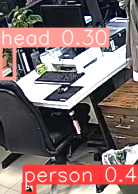

In [7]:
results.show()

In [8]:
def Head_Detection(model, img):
    
    img = Image.fromarray(img)
    img = F.adjust_brightness(img, 1.9)
    img = F.adjust_contrast(img,0.5)
    img = F.adjust_sharpness(img,1.2)   
    cordination = []
    
    with torch.no_grad(): results = model(np.array(img))
    if len(results.xywh[0]) == 0: pass
    else:
        df = pd.DataFrame(results.xywh[0].cpu())
        columnNames = ['x','y','w','h','confidance','lable']
        df.columns = columnNames
        for indx,res in enumerate(results.xywh[0]):            
            predict = int(df['lable'][indx])
            if predict == 1:
                res = np.array(res.detach().cpu())
#                 print("___________:",res[4]*100)
                if res[4]*100 > 60:#50
                    x = round(res[0])
                    y = round(res[1])
                    w = round(res[2])
                    h = round(res[3])
                    cordination.append([x,y])
#                     print("person x:", x)
#                     print("person y:", y)
            else:pass
        
    return cordination

In [9]:
def Chair_Detection(model, img, filter_ = 'chair'):
    img = Image.fromarray(img)
    img = F.adjust_brightness(img, 1.5)
    img = F.adjust_contrast(img,1)
    img = F.adjust_sharpness(img,1)

    cordination = []

    with torch.no_grad(): results = model(np.array(img))

    if len(results.xyxy[0]) == 0: pass
    else:        
        for indx,res in enumerate(results.xyxy[0]):
            
            predict = results.pandas().xyxy[0]['name'][indx]
            if predict == filter_:
                res = np.array(res.detach().cpu())
#                 print("chair ratio: ",res[4]*100)
                if res[4]*100 > 50:
                    x = round(res[0])
                    y = round(res[1])
                    w = round(res[2])
                    h = round(res[3])
                    cordination.append([x,y])
#                     print("chair x:", x)
#                     print("chair y:", y)
            else:pass
        
    return cordination

In [10]:
def Employee_Status(head_detection_model, chair_detection_model, img,img_original,person_id,table_cordination,count,last_status):
   
    person_cordination = Head_Detection(head_detection_model,img)
    chair_cordination = Chair_Detection(chair_detection_model,img)
    real_employee = []
    status = ""
    flag = -1
#     color = (255,255,255)
    img_original = cv2.cvtColor(np.array(img_original),cv2.COLOR_BGR2RGB)

    if count % 7 == 0:
        if person_cordination:
            if chair_cordination:
                for cord in person_cordination:
                    dist = np.linalg.norm(np.array(cord) - np.array(chair_cordination[0]))
                    real_employee.append(dist)
                if min(real_employee) < 130:#100
#                     print(1 ,"min: ",min(real_employee))
                    status = "person is working :) "
                    flag = 1
                    color = (0, 255, 0)
                else: 
#                     print(2 ,"min: ",min(real_employee))
                    status = "person is at table without sitting on chair -_- " 
                    flag = 0
                    color = (255, 0, 0)


            else:
#                 print(3)
                status = "person is at table without sitting on chair -_- " 
                flag = 0
                color = (255, 0, 0)
        else:
#             print(4)
            status = "person is not at table :( "
            flag = -1
            color = (0, 0, 255)
    else:
        status = last_status
        if status == "person is not at table :( " :
            flag = -1
            color = (0, 0, 255)
        elif status == "person is at table without sitting on chair -_- ": 
            flag = 0
            color = (255, 0, 0)
        elif status == "person is working :) ":
            flag = 1
            color = (0, 255, 0)
           
        else: pass

    try:
        img_original= cv2.rectangle(np.array(img_original), 
                                    (table_cordination[0],table_cordination[1],
                                     table_cordination[2],table_cordination[3]), 
                                     color, 1)

        img_original = cv2.putText(np.array(img_original),
                                   f"person id : {person_id} , status : {status}",
                                   (table_cordination[0], table_cordination[1]-10), 
                                    fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
                                    fontScale=0.5,color = color, thickness=1)
    except: pass
   
    img_original = cv2.resize(img_original, (1280, 720))
    img_original = cv2.cvtColor(np.array(img_original),cv2.COLOR_RGB2BGR)   
        
    return img_original,status 
    


In [11]:
def mouse_click(event, x, y, flags, param):
    global ROI_Region
    global img_original
    global filter_ 

    if event == cv2.EVENT_RBUTTONDOWN:
        ROI_Region = cv2.selectROI("Select Area",img_original)
        print(ROI_Region)
        cv2.destroyAllWindows()
    elif event == cv2.EVENT_MBUTTONDOWN: 
        filter_ = ''
        ROI_Region = [0,0,0,0]
    else: pass

In [12]:
import threading
threading.active_count()

5

In [13]:
# from threading import Thread

# class ThreadedCamera(object):
#     def __init__(self, source='cam:Sayda@0.0.0.0:88/videoMain'):

#         self.capture = cv2.VideoCapture(f'rtsp://{source}')
#         self.capture.set(cv2.CAP_PROP_BUFFERSIZE, 2)
#         self.thread = Thread(target = self.update, args = ())
#         self.thread.daemon = True
#         self.thread.start()s

#         self.status = False
#         self.frame  = None

#     def update(self):
#         while True:
#             if self.capture.isOpened(): (self.status, self.frame) = self.capture.read()
#             else: continue

#     def grab_frame(self):
#         if self.status: return self.frame
#         else: return None 
    
#     def end_frame(self):
#         self.capture.release()

In [14]:
from threading import Thread

class ThreadedVideo(object):
    def __init__(self, source='cam:Sayda@0.0.0.0:88/videoMain'):

        self.capture = cv2.VideoCapture(source)
        self.capture.set(cv2.CAP_PROP_BUFFERSIZE, 2)

        self.thread = Thread(target = self.update, args = ())
        self.thread.daemon = True
        self.thread.start()

        self.status = False
        self.frame  = None

    def update(self):
        while True:
            if self.capture.isOpened(): (self.status, self.frame) = self.capture.read()
            else: continue

    def grab_frame(self):
        if self.status: return self.frame
        else: return None 
    
    def end_frame(self):
        self.capture.release()

In [15]:
# from threading import Thread
# import cv2, time

# class ThreadedCamera(object):
#     def __init__(self, src=0):
#         self.capture = cv2.VideoCapture(f'rtsp://{src}')
# #         self.capture.set(cv2.CAP_PROP_BUFFERSIZE, 250)
       
#         # FPS = 1/X
#         # X = desired FPS
#         self.FPS = 1/30
#         self.FPS_MS = int(self.FPS * 1000)
        
#         # Start frame retrieval thread
#         self.thread = Thread(target=self.update, args=())
#         self.thread.daemon = True
#         self.thread.start()
#         self.status = False
        
#     def update(self):
#         while True:
#             if self.capture.isOpened():
#                 (self.status, self.frame) = self.capture.read()
#             time.sleep(self.FPS)
            
#     def show_frame(self):
#         cv2.imshow('frame', self.frame)
#         cv2.waitKey(self.FPS_MS)
        
#     def grab_frame(self):
#         if self.status: return self.frame
#         else: return None 
    
#     def end_frame(self):
#         self.capture.release()


In [16]:
# streamer = ThreadedCamera('rtsp:Sayda@0.0.0.0')
#rtsp:Sayda@0.0.0.0
streamer = ThreadedVideo('./samples/0/sample_3_lable_-1_2.mp4')
person_id = 512343
person_cordination =[95, 211, 177, 227]
#[325, 372, 325, 286]
#2r[25, 213, 61, 196] 
#r[95, 211, 177, 227]



In [17]:
import threading
threading.active_count()

6

In [ ]:
%%time


import time

frame_counter = 0
last_status = ''
while True: 
    img_original = streamer.grab_frame()
    try: img_original = Image.fromarray(img_original)
    except AttributeError: continue
       
    img_original = cv2.resize(np.array(img_original), (1280, 720))

 
    img = img_original.copy()
    
    
    try: 
        if person_cordination[0] == person_cordination[1] and person_cordination[2] == person_cordination[3]:
            if person_cordination[0] == 0 and person_cordination[0] == person_cordination[3]: pass
            else: 
                img = img[int(person_cordination[1]):int(person_cordination[1]+person_cordination[3]),int(person_cordination[0]):
                            int(person_cordination[0]+person_cordination[2])]
        else: 
            img = img[int(person_cordination[1]):int(person_cordination[1]+person_cordination[3]),int(person_cordination[0]):
                        int(person_cordination[0]+person_cordination[2])]

    except IndexError: pass


    if img_original is None: 
        img_res = np.zeros([720, 1280,3],dtype=np.uint8)
    else: 
        img_res,status = Employee_Status(head_detection_model, chair_detection_model, img,img_original,person_id,person_cordination,frame_counter,last_status)
        last_status = status
    
#     if status == "person is not at table :( ": # "person is working :) ":
# #     time = strftime("%a, %d %b %Y %H:%M:%S +0000", gmtime())
# #     cv2.imwrite(f'database/{status}-{time}.jpg', img)
#         cv2.imwrite(f'database/frame%d.jpg'% frame_counter, img)

    delay = 0.01 # delay value in seconds
    time.sleep(delay) 
    frame_counter = frame_counter + 1
    print(frame_counter)
    img_res = cv2.resize(img_res, (1280, 720))
    cv2.imshow('Empty Table Detection', np.array(img_res))

    cv2.setMouseCallback('Empty Table Detection', mouse_click)
    if cv2.waitKey(1) & 0xFF == ord('q'): #  frame_counter == 18:#
        cv2.destroyAllWindows()
        streamer.end_frame()
        break
        

#with gpu 
# 604 frame
# CPU times: total: 6.92 / 604 = 0.0114569536423841 s
# Wall time: 2.52 / 604 = 0.0041721854304636 s

#with gpu 
# 18 frame
# CPU times: total: 6.92 / 18 = 0.3844444444444444 s
# Wall time: 2.52 / 18 = 0.14 s


#without gpu
# cpu


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [ ]:
threading.active_count()

In [ ]:
# streamer = ThreadedVideo('./samples/0/sample_3_lable_-1_2.mp4')

In [ ]:
# # %%time

# start = torch.cuda.Event(enable_timing=True)
# end = torch.cuda.Event(enable_timing=True)
# start.record()

# path = './samples/0/sample_3_lable_-1_2.mp4'


# cap = cv2.VideoCapture(path)

# if (cap.isOpened() == False): 
#     print("Error opening video stream or file")

# frame_counter = 0
# last_status = ''
# while True:
#     ret ,img_original = cap.read()
    
#     if ret == True:
#         img = img_original.copy()

#         try: 
#             if person_cordination[0] == person_cordination[1] and person_cordination[2] == person_cordination[3]:
#                 if person_cordination[0] == 0 and person_cordination[0] == person_cordination[3]: pass
#                 else: 
#                     img = img[int(person_cordination[1]):int(person_cordination[1]+person_cordination[3]),int(person_cordination[0]):
#                                 int(person_cordination[0]+person_cordination[2])]
#             else: 
#                 img = img[int(person_cordination[1]):int(person_cordination[1]+person_cordination[3]),int(person_cordination[0]):
#                             int(person_cordination[0]+person_cordination[2])]

#         except IndexError: pass


#         if img_original is None: 
#             img_res = np.zeros([720, 1280,3],dtype=np.uint8)
#         else: 
#             img_res,status = Employee_Status(head_detection_model, chair_detection_model, img,img_original,person_id,person_cordination,frame_counter,last_status)
#             last_status = status

#         frame_counter = frame_counter + 1
#         if(frame_counter%100 == 0):
#             print(frame_counter)
#         img_original = cv2.resize(img_original, (1280, 720))
#         cv2.imshow('Empty Table Detection', np.array(img_original))

#         if cv2.waitKey(1) & frame_counter == 604:#xFF == ord('q'):
#             break
#     else:
#         pass

# cap.release()
 
# # Closes all the frames
# cv2.destroyAllWindows()
# end.record()


# torch.cuda.synchronize()

# print(start.elapsed_time(end))
   
# # CPU times: total: 1min 8s  ==>  68 s / 604 frame = 0.1125827814569536 s
# # Wall time: 58.7 s  / 604 frame = 0.0971854304635762 s
# 60851.171875

In [ ]:
frame_counter